In [ ]:
!pip install scikit-learn-extra

In [ ]:
!pip install -q pyyaml h5py
!pip install vaderSentiment

In [ ]:
#import neccesary packages
import tensorflow_hub as hub
import tensorflow as tf
import pickle
from keras import backend as K
import numpy as np
from sklearn_extra.cluster import KMedoids
from tensorflow import keras
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from datetime import datetime
from scipy.spatial import distance_matrix
import sys

In [ ]:
#mount your google drive here
print(tf.__version__)
from google.colab import drive 
drive.mount('/content/drive')

2.6.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import datasets

In [ ]:
#directory of the datasets. Github provides these files in the form of pickle files
#dir = "../datasets/hotel/"
dir = "./"
with open (dir + 'y_train', 'rb') as fp:
    y_train = pickle.load(fp)

with open (dir + 'train_not_clean', 'rb') as fp:
    train_not_clean = pickle.load(fp)

with open (dir + 'test_not_clean', 'rb') as fp:
    test_not_clean = pickle.load(fp)

with open (dir + 'y_test', 'rb') as fp:
    y_test = pickle.load(fp)

In [ ]:
print(train_not_clean[:10])
print(y_train[:10])

["RENT A STEAM CLEANER. The location is very, very inconvenient, but I am sure that is nothing they can help, it is just how the city has grown around their location. I would have rated the room as a 4 or 5 for clean if the sofa was not so disgusting. I literally covered it with a sheet just to sit on it. There was not one inch of surface that was not covered with a greasy/dirty stain. I would have switched rooms if I hadn't already unloaded all of my stuff in the rain before I turned on the lights to reveal the nasty sofa. Otherwise, the room was clean and comfortable. It would be worth a couple of hundred dollars to get a steam cleaner and clean the sofas in each room. Not to mention how unsanitary it is", "Great hotel and staff - recommend. I came in late after a long drive from Vegas ending in a whole lot of highway exits and concentration to get to Napa. I was greeted by a friendly night staff who was expecting me, and (not sure of his name) made me feel more relaxed immediately. 

# Data preprocessing

In [ ]:
#this method is to split the paragraphs into sentences
def gen_sents(para):
    res = []
    for p in para:
        sents = p.split(".")
        res.append(sents)
    return res


train_noclean_sents = gen_sents(train_not_clean)
test_noclean_sents = gen_sents(test_not_clean)

In [ ]:
x_train = train_noclean_sents
x_test = test_noclean_sents

#optional: just to make sure the label values are integers
y_train = [int(y) for y in y_train]
y_test = [int(y) for y in y_test]


print('test_noclean_sents ', len(test_noclean_sents), len(test_noclean_sents[0]), test_noclean_sents[0])
print('y_train: ', y_train[:10])
print('y_test: ', y_test[:10])

test_noclean_sents  902 7 ['Share your room with roach or bug', ' Roach in the room but the staff said its just a bug not a roach, like that made it any better', ' Big hole in the bathroom wall were this bug/roach came out of', ' Wonder what other rodent will come out of the wall', 'Thank you for providing us with your feedback', ' I would like to apologize for any of the inconveniences you may have experienced during your time with us', ' I wish that I had been notified of your concerns before you had checked out and I would like to apologize on behalf of our staff']
y_train:  [1, 1, 1, 0, 1, 1, 0, 0, 1, 1]
y_test:  [0, 0, 1, 1, 0, 1, 0, 0, 0, 1]


In [ ]:
#import Google Sentence encoder, to convert sentences into vector values
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print("module %s loaded" % module_url)

def embed(input):
    return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
#sampling training data (sentences)
sample_sentences = []
#choose with data to sample
for p in train_noclean_sents[:1000]:
    sample_sentences.extend(p)

#compute vector values of sentences
sample_sent_vect = embed(sample_sentences)
print(sample_sent_vect)

tf.Tensor(
[[-0.02057868 -0.02088437  0.04719457 ... -0.05737035  0.0809434
   0.03041554]
 [ 0.00906794 -0.03493961 -0.02079896 ... -0.04224585  0.0316922
   0.02062658]
 [-0.05278953  0.00524479 -0.04006644 ... -0.05303752  0.07519065
  -0.00645196]
 ...
 [-0.01198282 -0.03123995 -0.04763544 ... -0.02125541 -0.00142225
   0.04536419]
 [ 0.00181901 -0.06974981 -0.05855938 ...  0.03950791  0.06799415
   0.08365905]
 [-0.07305439 -0.02952773  0.03002902 ... -0.0527765   0.01056046
   0.04155547]], shape=(11747, 512), dtype=float32)


# Prototype initialization

In [ ]:
k_protos, vect_size = 10, 512
kmedoids = KMedoids(n_clusters=k_protos, random_state=0).fit(sample_sent_vect)
k_cents = kmedoids.cluster_centers_
print(k_cents.shape)

(10, 512)


# Model training and testing

In [ ]:
#import protoryNet, we recommend you download the protoryNet.py file from Github to have the most updated version
from protoryNet import ProtoryNet

In [ ]:
pNet = ProtoryNet() 

In [ ]:
model = pNet.createModel(k_cents)

[db] model.input =  KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.string, name='input_1'), name='input_1', description="created by layer 'input_1'")
[db] protoLayerName =  proto_layer
[db] protoLayer =  <protoryNet.ProtoryNet.createModel.<locals>.prototypeLayer object at 0x7fc9346aa2d0>
[db] protoLayer.output =  (<KerasTensor: shape=(None, None, 10) dtype=float32 (created by layer 'proto_layer')>, <KerasTensor: shape=(10, 512) dtype=float32 (created by layer 'proto_layer')>)
[db] distanceLayer.output =  KerasTensor(type_spec=TensorSpec(shape=(None, None, 10), dtype=tf.float32, name=None), name='distance_layer/PartitionedCall:0', description="created by layer 'distance_layer'")
Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
keras_layer (Kera

In [ ]:
pNet.train(x_train,y_train,x_test,y_test)

Epoch  0
i =   0
1/1 [==============================] - 11s 11s/step - loss: 0.7002
Evaluating y_pred, y  [0.4977372] 0 0
Evaluating y_pred, y  [0.5068006] 1 1
Evaluate on valid set:  0.573170731707317
This is the best eval res, saving the model...
saving model now = 2021-08-26 19:46:20.007901
date and time = 26_08_2021_19_46_20
just saved
i =   50
1/1 [==============================] - 0s 238ms/step - loss: 0.6345
i =   100
1/1 [==============================] - 0s 237ms/step - loss: 0.8884
i =   150
1/1 [==============================] - 0s 239ms/step - loss: 0.6312
i =   200
1/1 [==============================] - 0s 234ms/step - loss: 0.8689
Evaluating y_pred, y  [0.5622301] 1 0
Evaluating y_pred, y  [0.61904633] 1 1
Evaluate on valid set:  0.5254988913525499
i =   250
1/1 [==============================] - 0s 237ms/step - loss: 0.8369
i =   300
1/1 [==============================] - 0s 237ms/step - loss: 0.6128
i =   350
1/1 [==============================] - 0s 243ms/step - loss: 

KeyboardInterrupt: ignored

In [ ]:
#test giving a prediction value to an input
testS = ["Generally I like the hotel and will come back",
         "It's a small hotel",
         "The room is nice, clean and suitable for a nice stay however",
         "It's one of the best in the area"]
pNet.predict(testS)

array([0.7113554], dtype=float32)

# Show the prototypes

In [ ]:
#show the list of prototypes
pNet.showPrototypes(sample_sentences,sample_sent_vect)

[db] p_count =  0
[db] p_count =  1
[db] p_count =  2
[db] p_count =  3
[db] p_count =  4
[db] p_count =  5
[db] p_count =  6
[db] p_count =  7
[db] p_count =  8
[db] p_count =  9
Prototypes: 
Overall I was very happy with the hotel and would definitely stay here again
We were only in the solamar hotel for 2 days but it was one of the best hotel stays we've ever had
It was my first stay in a kimpton hotel and now I don't want to stay anywhere else
Was a small hotel which was fine for us
I would have given this hotel a 5 star but we didn't like the parking situation
I am glad you enjoyed your stay and look forward to have you back
The only good thing was it's location and price but I guess you get what you pay for
We were only in the solamar hotel for 2 days but it was one of the best hotel stays we've ever had
My only complaint was that the room was somewhat small for a hotel of this quality
The Hotel had a nice room, Clean, and everything you needed to just have a nice stay


In [ ]:
#the number of closest sentences to each prototypes
pNet.protoFreq(sample_sent_vect)

Prototype freq =  {0: 910, 1: 1128, 2: 1781, 3: 1585, 4: 1192, 5: 1737, 6: 888, 7: 0, 8: 1729, 9: 797}
sorted : [(2, 1781), (5, 1737), (8, 1729), (3, 1585), (4, 1192), (1, 1128), (0, 910), (6, 888), (9, 797), (7, 0)]


In [ ]:
#list of prototypes
pNet.mappedPrototypes

{0: 'Overall I was very happy with the hotel and would definitely stay here again',
 1: "We were only in the solamar hotel for 2 days but it was one of the best hotel stays we've ever had",
 2: "It was my first stay in a kimpton hotel and now I don't want to stay anywhere else",
 3: 'Was a small hotel which was fine for us',
 4: "I would have given this hotel a 5 star but we didn't like the parking situation",
 5: 'I am glad you enjoyed your stay and look forward to have you back',
 6: "The only good thing was it's location and price but I guess you get what you pay for",
 7: "We were only in the solamar hotel for 2 days but it was one of the best hotel stays we've ever had",
 8: 'My only complaint was that the room was somewhat small for a hotel of this quality',
 9: 'The Hotel had a nice room, Clean, and everything you needed to just have a nice stay'}

In [ ]:
#testing generating prototype trajectory. "scores" stores the sentiment scores of the mapped prototypes
testS = ["Generally I like the hotel and will come back",
         "It's a small hotel",
         "The room is nice, clean and suitable for a nice stay however",
         "It's one of the best in the area"]
scores = pNet.showTrajectory(testS,sample_sentences,sample_sent_vect)
print(scores)

[db] mappedProtos  ['Overall I was very happy with the hotel and would definitely stay here again', 'Was a small hotel which was fine for us', 'The Hotel had a nice room, Clean, and everything you needed to just have a nice stay', "We were only in the solamar hotel for 2 days but it was one of the best hotel stays we've ever had"]
[0.88565, 0.60115, 0.9037, 0.88915]


In [ ]:
def drawLines(a):
  print(a)
  fig = plt.figure()

  plt.plot([i + 1 for i in range(len(a))], a, marker='o', color='red',
              linewidth=2)
  plt.ylim((0, 1.05))
  plt.yticks(fontsize=25)
  plt.xticks([i + 1 for i in range(len(a))], [str('S') + str(i+1) for i in range(len(a))], fontsize=25)
  plt.show()

[0.88565, 0.60115, 0.9037, 0.88915]


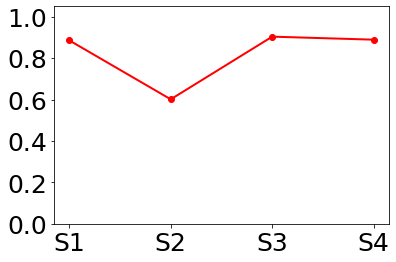

In [ ]:
import matplotlib.pyplot as plt
drawLines(scores)